In [161]:
from lib.threshold_tree import ThresholdTree
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer, load_diabetes

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create dataset and perform Clustering

In [162]:
# This block is in progress

# data = pd.read_csv('datasets/diabetes.csv')
# data.head()

# X = data.drop(columns=['Outcome'])
# _y = data['Outcome']

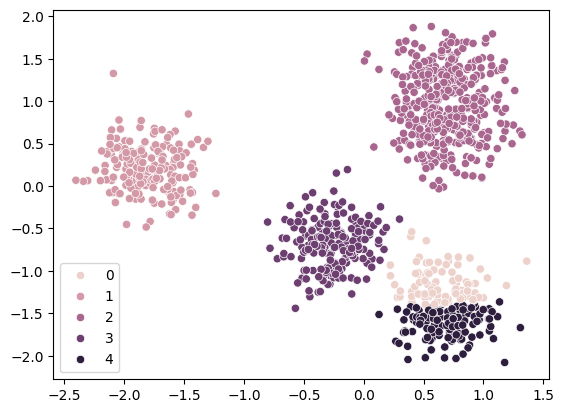

[[ 0.70807304 -0.88678045]
 [ 0.71314827  1.47968247]
 [ 1.11072852  1.35983673]
 [ 0.40281284 -1.37423637]
 [ 0.66730811  0.67436039]
 [ 0.55276434  1.29422211]
 [-0.23917183 -0.90436338]
 [-1.87954962  0.35802478]
 [ 0.48664084 -1.27559738]
 [-1.82441501  0.1263172 ]]


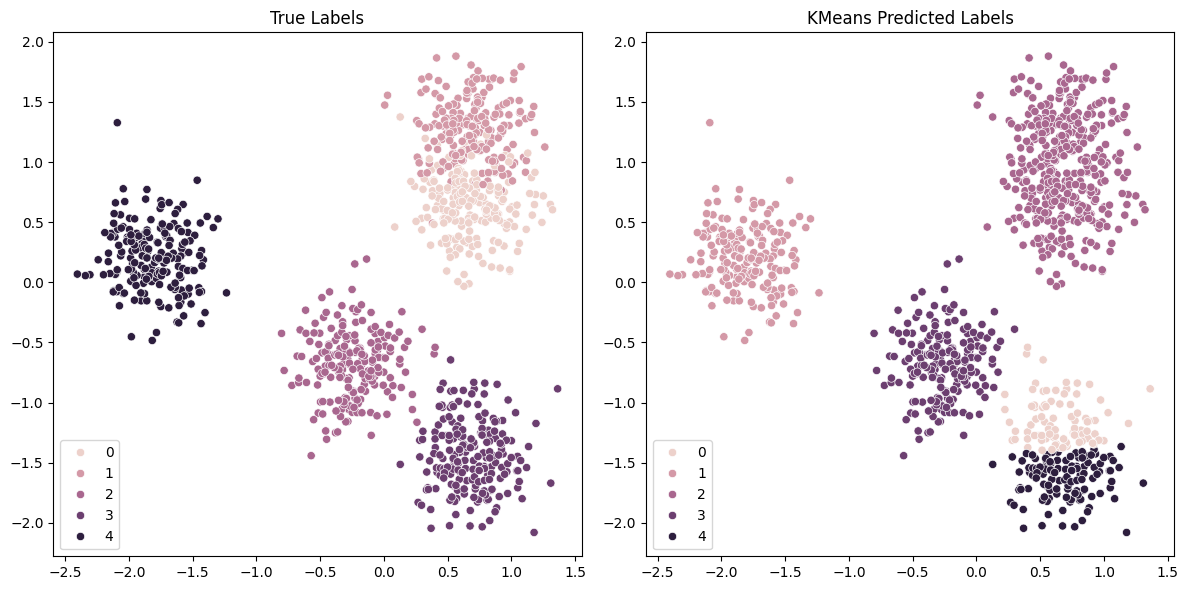

In [163]:
dims = 2
n = 1000
k = 5
min_impurity_decrease = 0.1 # minimum impurity decrease to split for DTC
threshold_change = 0.01 # amount that will be changed to either side of the threshold
robustness_factor = 0.7 # DTC robustness post processing factor
seed = 4

X, _y = make_blobs(centers=k, cluster_std=1.4, n_features=dims, n_samples=n, random_state=seed)
# data = load_iris()
# X, _y = data.data, data.target

# Normalize data
X = StandardScaler().fit_transform(X)

model = KMeans(n_clusters=k, random_state=seed)
model.fit(X)

centers = model.cluster_centers_
y = model.predict(X)
dims = X.shape[1]
n = X.shape[0]
k = len(centers)

# plot the clusters
if dims > 2:
    pca = PCA(n_components=2)
    embed_X = pca.fit_transform(X)
    sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, legend='full')
else:
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, legend='full')
plt.show()

print(X[:10])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot with true labels
if dims > 2:
    sns.scatterplot(ax=axes[0], x=embed_X[:, 0], y=embed_X[:, 1], hue=_y, legend='full')
    axes[0].set_title("True Labels")
else:
    sns.scatterplot(ax=axes[0], x=X[:, 0], y=X[:, 1], hue=_y, legend='full')
    axes[0].set_title("True Labels")

# Plot with KMeans labels
if dims > 2:
    sns.scatterplot(ax=axes[1], x=embed_X[:, 0], y=embed_X[:, 1], hue=y, legend='full')
    axes[1].set_title("KMeans Predicted Labels")
else:
    sns.scatterplot(ax=axes[1], x=X[:, 0], y=X[:, 1], hue=y, legend='full')
    axes[1].set_title("KMeans Predicted Labels")

plt.tight_layout()
plt.show()

# Choose instance and target

In [164]:
# instance_index = np.argwhere(y == 3)[0][0]
instance_index = y.argmin()
instance = X[instance_index]
target_class = 2
target_point = centers[target_class, :]

print("")
print(f"Instance class: {y[instance_index]}, point: {instance}")
print(f"Target center class: {target_class}, point: {target_point}\n")


Instance class: 0, point: [ 0.70807304 -0.88678045]
Target center class: 2, point: [0.68588525 0.96138833]



# Find cfs using Decision Tree Classifier

DTC accuracy: 0.992
Instance: [ 0.70807304 -0.88678045]
Instance prediction : [0]

CFS: [[ 0.70807302 -0.2015838 ]]
CF predictions:  [0]


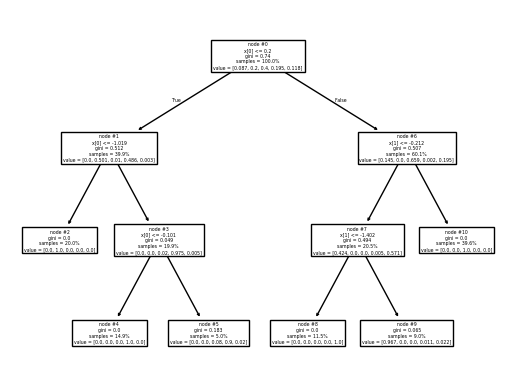

In [165]:
threshold_tree = ThresholdTree(model, centers, X, y)

cfs, cfs_prime = threshold_tree.find_counterfactuals_dtc(instance, target_class, min_impurity_decrease=min_impurity_decrease, threshold_change=threshold_change, robustness_factor=robustness_factor)
print(f'Instance: {instance}')
print(f'Instance prediction : {model.predict([instance])}')
print("")
print(f'CFS: {cfs}')
print(f'CF predictions: ', model.predict(cfs))
threshold_tree.print_dtc_tree()

# Find cfs using Iterative Mistake Minimization(IMM)

In [166]:
cf, cf_prime = threshold_tree.find_counterfactuals_imm(instance, target_class, threshold_change=threshold_change)
print("Instance: ", instance)
print("Counterfactual: ", cf)
print("")
print("Original class: ", model.predict([instance]))
print("Counterfactual class: ", model.predict(cf))
threshold_tree.print_imm_tree()

Instance:  [ 0.70807304 -0.88678045]
Counterfactual:  [[ 0.70807304 -0.32432903]]

Original class:  [0]
Counterfactual class:  [0]
├── L0: f0 < -0.5586556401757489
│   ├── L1, C: 1
│   └── L1: f0 < 0.21605130520445623
│       ├── L2, C: 3
│       └── L2: f1 < -0.3343290328683218
│           ├── L3: f1 < -1.388647717228554
│           │   ├── L4, C: 4
│           │   └── L4, C: 0
│           └── L3, C: 2



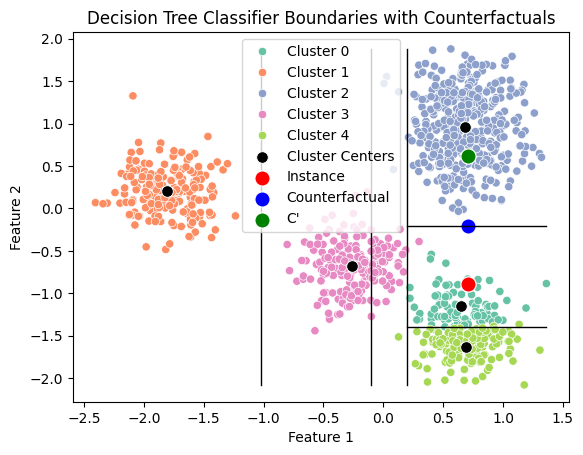

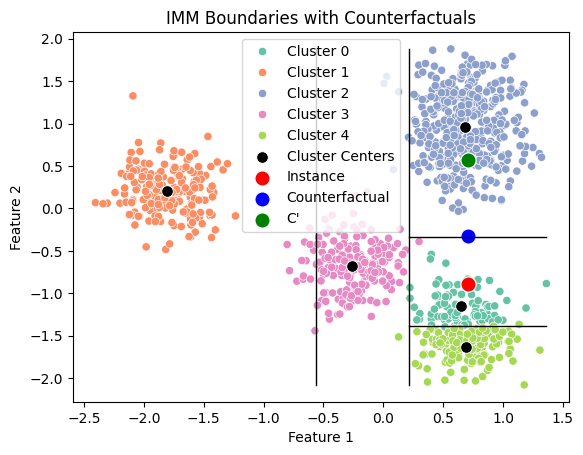

In [167]:
threshold_tree.plot_dtc_tree()
threshold_tree.plot_imm_tree()

Random Forest accuracy: 0.997


IndexError: index 1 is out of bounds for axis 0 with size 1

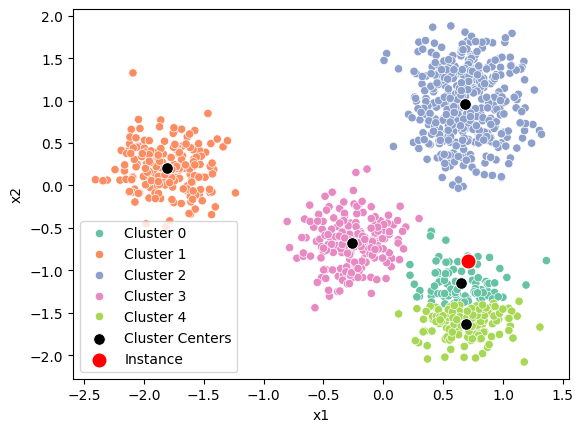

In [168]:
cf = threshold_tree.find_counterfactuals_rf(instance, target_class, threshold_change=threshold_change, n_estimators=20, ratio_of_trees=0.4)
threshold_tree.plot_rf_tree()